In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
import pandas as pd
import sklearn
import sklearn.svm, sklearn.discriminant_analysis, sklearn.linear_model
import time
import scipy.stats
import statsmodels
from statsmodels.stats.anova import AnovaRM
import copy


root = '/usr/local/serenceslab/maggie/shapeDim/'

sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import file_utils, data_utils
from code_utils import decoding_utils
from code_utils import stats_utils, plot_utils


In [26]:
task_names = ['Linear (1)','Linear (2)','Checker', 'Repeat'];
n_tasks = len(task_names)
task_colors = np.flipud(cm.GnBu(np.linspace(0,1,5))[1:,:])

n_subjects = 10
# n_subjects = 3;
# subjects = np.arange(8, 11)
subjects = np.arange(1, 11)
subcolors = cm.Dark2(np.linspace(0,1,n_subjects))

In [27]:
lab = dict()
for ss in subjects:
    
    # get labels for all the trials, this subject
    main_labels = data_utils.load_main_task_labels(ss)
    rep_labels = data_utils.load_repeat_task_labels(ss)
    lab[ss] = pd.concat([main_labels, rep_labels], axis=0)
   

In [28]:
from code_utils import grid_utils
grid_pts = grid_utils.get_main_grid()
# NOTE i am swapping the columns here
# because this is the order you get from doing np.unique(pts)
# this is the actual order that the predictions 1-16 of this classifier
# correspond to. 
grid_pts = grid_pts[:,[1,0]] 

In [29]:
# save_folder = os.path.join(root, 'Analysis', 'decoding_results')
# save_filename = os.path.join(save_folder, 'decode_multiclass_withintask.npy')
# dec_withintask = np.load(save_filename, allow_pickle=True).item()
# dec_withintask.keys()


In [30]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')

save_filename1 = os.path.join(save_folder, 'decode_multiclass_withintask.npy')
print(save_filename1)
print(time.ctime(os.path.getmtime(save_filename1)))
dec_withintask1 = np.load(save_filename1, allow_pickle=True).item()

save_filename2 = os.path.join(save_folder, 'decode_multiclass_withintask_newsubs.npy')
print(save_filename2)
print(time.ctime(os.path.getmtime(save_filename2)))
dec_withintask2 = np.load(save_filename2, allow_pickle=True).item()
dec_withintask2.keys()

dec_withintask = dict([])
for kk in list(dec_withintask1.keys()):
    print(kk)
    if kk not in ['preds_all','probs_all']:
        # print(dec_withintask1[kk].shape)
        dec_withintask[kk] = np.concatenate([dec_withintask1[kk], dec_withintask2[kk]], axis=0)
        print(dec_withintask[kk].shape)
    else:
        dec_withintask[kk] = dec_withintask1[kk]
        # print(dec_withintask1[kk].keys())
        for si in dec_withintask2[kk].keys():
            # print(si, si+7)
            dec_withintask[kk][si+7] = dec_withintask2[kk][si]
        print(dec_withintask[kk].keys())
        
dec_withintask['roi_names'] = dec_withintask1['roi_names']
dec_withintask['grid_pts'] = dec_withintask1['grid_pts']

/usr/local/serenceslab/maggie/shapeDim/Analysis/decoding_results/decode_multiclass_withintask.npy
Fri Jun  2 12:40:24 2023
/usr/local/serenceslab/maggie/shapeDim/Analysis/decoding_results/decode_multiclass_withintask_newsubs.npy
Tue Aug 13 08:41:26 2024
acc_bytask
(10, 8, 4)
dprime_bytask
(10, 8, 4)
preds_all
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
probs_all
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
acc_each_cval
(10, 8, 4, 12, 20)
best_cval
(10, 8, 4, 12)
grid_pts
(32, 2)
roi_names
(16,)


In [31]:
roi_names = dec_withintask['roi_names']
roi_names[-1] = 'IPS'
n_rois = len(roi_names)
roi_names

['V1', 'V2', 'V3', 'V3AB', 'hV4', 'LO1', 'LO2', 'IPS']

#### Compute binary classification accuracy for different sets of trials
Far = furthest rows from boundary

Middle = closer rows to boundary, but still in main grid


In [32]:
n_tasks = 4

conf_allmaintrials = np.zeros((n_subjects, n_rois, n_tasks, 2))
dprime_allmaintrials = np.zeros((n_subjects, n_rois, n_tasks, 2))
acc_allmaintrials = np.zeros((n_subjects, n_rois, n_tasks, 2))

conf_fartrials = np.zeros((n_subjects, n_rois, n_tasks, 2))
dprime_fartrials = np.zeros((n_subjects, n_rois, n_tasks, 2))
acc_fartrials = np.zeros((n_subjects, n_rois, n_tasks, 2))

conf_midtrials = np.zeros((n_subjects, n_rois, n_tasks, 2))
dprime_midtrials = np.zeros((n_subjects, n_rois, n_tasks, 2))
acc_midtrials = np.zeros((n_subjects, n_rois, n_tasks, 2))

for si, ss in enumerate(subjects):

    # loop over tasks
    for ti, tt in enumerate([1,2,3,4]):
        
        l = lab[ss][lab[ss]['task']==tt]
        
        pt_labs = np.array([l['ptx'], l['pty']]).T
        
        is_main_grid = l['is_main_grid']==1
        
        # use correct trials only here
        correct = np.array(l['subject_correct'])
        
        # loop over "axes" - which boundary to compute accuracy for
        for ii in [0,1]:

            categ_actual = l['categ_task%d'%(ii+1)]
            coord_actual = pt_labs[:,ii].round(2)
           
            # far is the furthest from bound
            # middle is second furthest
            dist_from_center = l['dist_from_bound%d'%(ii+1)].round(2)
            is_near = dist_from_center<0.8
            is_far = (dist_from_center==2.4) & is_main_grid
            is_middle = (dist_from_center==0.8) & is_main_grid
           
            # loop over ROIs
            for ri in range(n_rois):

                pred = dec_withintask['preds_all'][si][ri][ti].astype(int)
                
                # binarize the predictions of 16-way classifier into 2 categories
                # based on current axis "ii"
                coords_pred = grid_pts[pred]
                categ_pred = grid_utils.get_categ(coords_pred, ii+1)
                
                prob = dec_withintask['probs_all'][si][ri][ti]
                
                # "confidence" in assignment to category 2 vs 1
                # group the 16 points into categories w/r/t relevant axis
                g1 = grid_utils.get_categ(grid_pts, ii+1)==1
                p_categ1 = np.sum(prob[:,g1], axis=1)
                g2 = grid_utils.get_categ(grid_pts, ii+1)==2
                p_categ2 = np.sum(prob[:,g2], axis=1)
                
                # signed confidence will be: p(correct) - p(incorrect)
                signedconf = np.zeros_like(p_categ1)
                signedconf[categ_actual==1] = p_categ1[categ_actual==1] - p_categ2[categ_actual==1]
                signedconf[categ_actual==2] = p_categ2[categ_actual==2] - p_categ1[categ_actual==2]
                
                
                
                # inds = is_main_grid & correct
                # inds = is_main_grid
                # can't have the "correct" selector here
                # because it biases us to have more "far" than "middle" trials
                # and this influences the result.
                
                
                
#                 conf_allmaintrials[si,ri,ti,ii] = np.mean(signedconf[inds])
            
#                 d = stats_utils.get_dprime(categ_pred[inds], categ_actual[inds])
#                 dprime_allmaintrials[si,ri,ti,ii] = d;
                
#                 acc_allmaintrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])
                
                # far trials
                inds = is_far & correct
                                                          
                conf_fartrials[si,ri,ti,ii] = np.mean(signedconf[inds])
            
                d = stats_utils.get_dprime(categ_pred[inds], categ_actual[inds])
                dprime_fartrials[si,ri,ti,ii] = d;
                
                acc_fartrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])
                
                # middle trials
                inds = is_middle & correct
                                                      
                conf_midtrials[si,ri,ti,ii] = np.mean(signedconf[inds])
            
                d = stats_utils.get_dprime(categ_pred[inds], categ_actual[inds])
                dprime_midtrials[si,ri,ti,ii] = d;
                
                acc_midtrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])
                
                

In [33]:
plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 16)
figfolder = os.path.join(root, 'Analysis','figures')

[-0.04542350400620719, 0.8686700305046519]
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/multi_binary_conf_Far.pdf
[-0.03898403468950567, 0.5543294697509205]
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/multi_binary_conf_Near.pdf


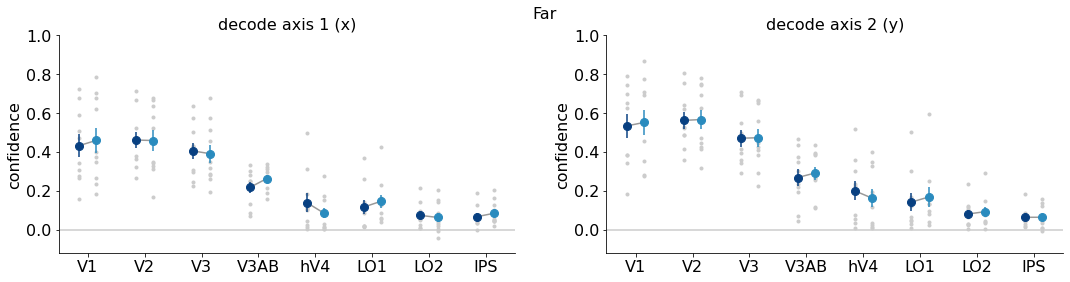

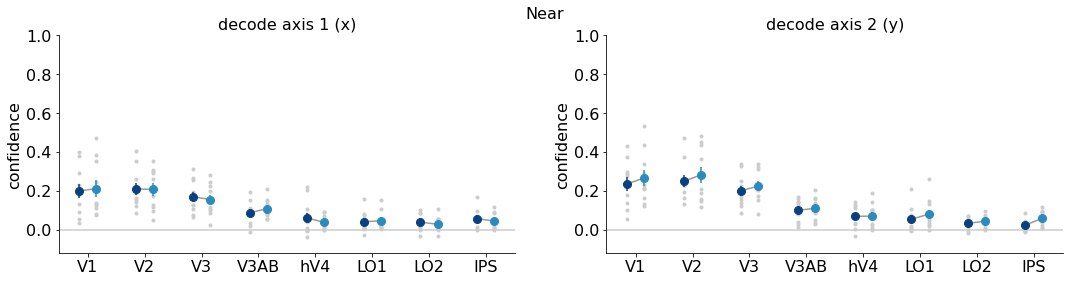

In [34]:
ti_plot = [0,1]

x_jitter = np.linspace(-0.15, 0.15,2)

for conf_vals, name in zip([conf_fartrials, conf_midtrials], \
                     ['Far','Near']):    
    
    print([np.min(conf_vals.ravel()),np.max(conf_vals.ravel())])
    plt.figure(figsize=(18,4))

    for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)']):

        ax = plt.subplot(1,2,ii+1)

        plt.axhline(0, color=[0.8, 0.8, 0.8])

        lh = []

        for ti in ti_plot:

            x_ticks = np.arange(n_rois) + x_jitter[ti]

            vals = conf_vals[:,:,ti,ii]
            meanvals = np.mean(vals, axis=0)
            semvals = np.std(vals, axis=0)/np.sqrt(n_subjects)

            plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti], alpha=1, \
                     markersize=8, \
                     # markerfacecolor='none', \
                    )
            h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
            lh.append(h)
            
        for ri in range(n_rois):
            
            meanvals = np.mean(conf_vals[:,ri,ti_plot,ii], axis=0)
            plt.plot([ri+x_jitter[0], ri+x_jitter[1]], meanvals,'-',color=[0.6, 0.6, 0.6],zorder=-5)

            plt.plot(ri+x_jitter, conf_vals[:,ri,ti_plot,ii].T, '.', color=[0.8, 0.8, 0.8], zorder=-10)
            
        # plt.ylim([-0.10, 0.90])
        plt.ylim([-0.12, 1.0])
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        plt.xticks(np.arange(n_rois), roi_names)
        plt.ylabel('confidence')

        # plt.legend(lh,np.array(task_names)[ti_plot])

        plt.title('decode %s'%axis_name)

    plt.suptitle('%s'%name)
    
    figname = os.path.join(figfolder, 'multi_binary_conf_%s.pdf'%(name))
    print(figname)
    plt.savefig(figname)


#### three-way RM anova
save result to disk bc shuffled test is very slow

In [20]:
figfolder = os.path.join(root, 'Analysis','figures')

for xx, [cvals, diffname] in enumerate(zip([conf_fartrials, conf_midtrials], \
                        ['Far','Near'])):

    
    vals = copy.deepcopy(cvals[:,:,0:2,0:2])

    anova_result = stats_utils.rmanova_3way(vals, ['ROI','Task','Boundary'], \
                                            # do_shuffle=False)
                                           do_shuffle=True, n_iter=10000, rndseed = 675677+xx)

    anova_result['Pr > F'] = anova_result['Pr > F'].round(4)

    tablename = os.path.join(figfolder, 'decode_16way_binary_conf_lin1vs2_rm_anova_%s.csv'%(diffname))
    
    print(tablename)
    anova_result.to_csv(tablename)

/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decode_16way_binary_conf_lin1vs2_rm_anova_Far.csv
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decode_16way_binary_conf_lin1vs2_rm_anova_Near.csv


#### print test results

In [35]:
for diffname in ['Far','Near']:
    
    tablename = os.path.join(figfolder, 'decode_16way_binary_conf_lin1vs2_rm_anova_%s.csv'%(diffname))
    print(tablename)
    print(time.ctime(os.path.getmtime(tablename)))
    anova_result = pd.read_csv(tablename, index_col=0)
    print('\nAnova for confidence, %s trials'%(diffname))
    
    print(anova_result)

/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decode_16way_binary_conf_lin1vs2_rm_anova_Far.csv
Thu Dec 12 12:16:25 2024

Anova for confidence, Far trials
                     F Value  Num DF  Den DF  Pr > F  p (permutation)
ROI                54.435483     7.0    63.0  0.0000           0.0000
Task                0.218732     1.0     9.0  0.6511           0.6569
Boundary           49.963924     1.0     9.0  0.0001           0.0000
ROI:Task            0.818205     7.0    63.0  0.5757           0.5706
ROI:Boundary        6.583088     7.0    63.0  0.0000           0.0000
Task:Boundary       0.035206     1.0     9.0  0.8553           0.8568
ROI:Task:Boundary   1.149758     7.0    63.0  0.3444           0.3475
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decode_16way_binary_conf_lin1vs2_rm_anova_Near.csv
Thu Dec 12 12:27:51 2024

Anova for confidence, Near trials
                     F Value  Num DF  Den DF  Pr > F  p (permutation)
ROI                30.129950     7.0  

#### two-way RM anova, within each distance bin

In [22]:
for cvals, diffname in zip([conf_fartrials, conf_midtrials], \
                        ['Far','Near']):

    for ii, axis_name in enumerate(['axis1','axis2']):

        vals = copy.deepcopy(cvals[:,:,0:2,ii])

        anova_result = stats_utils.rmanova_2way(vals, ['ROI','Task'], \
                                                # do_shuffle=False);
                                                do_shuffle=True, n_iter=10000, rndseed = 243434+ii)

        
        anova_result['Pr > F'] = anova_result['Pr > F'].round(4)
    
        tablename = os.path.join(figfolder, 'decode_16way_binary_conf_rm_anova_%s_%s.csv'%(axis_name, diffname))
    
        print(tablename)
        anova_result.to_csv(tablename)

/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decode_16way_binary_conf_rm_anova_axis1_Far.csv
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decode_16way_binary_conf_rm_anova_axis2_Far.csv
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decode_16way_binary_conf_rm_anova_axis1_Near.csv
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decode_16way_binary_conf_rm_anova_axis2_Near.csv


In [12]:
for diffname in ['Far','Near']:
    for axis_name in ['axis1','axis2']:

        tablename = os.path.join(figfolder, 'decode_16way_binary_conf_rm_anova_%s_%s.csv'%(axis_name, diffname))
        print(tablename)
        print(time.ctime(os.path.getmtime(tablename)))
        anova_result = pd.read_csv(tablename, index_col=0)
        print('\nAnova for %s confidence, %s trials'%(axis_name, diffname))
        print(anova_result)

/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decode_16way_binary_conf_rm_anova_axis1_Far.csv
Thu Dec 12 12:34:23 2024

Anova for axis1 confidence, Far trials
            F Value  Num DF  Den DF  Pr > F  p (permutation)
ROI       46.498774     7.0    63.0  0.0000           0.0000
Task       0.133690     1.0     9.0  0.7231           0.7281
ROI:Task   1.257827     7.0    63.0  0.2857           0.2855
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decode_16way_binary_conf_rm_anova_axis2_Far.csv
Thu Dec 12 12:40:51 2024

Anova for axis2 confidence, Far trials
            F Value  Num DF  Den DF  Pr > F  p (permutation)
ROI       52.924861     7.0    63.0  0.0000           0.0000
Task       0.316234     1.0     9.0  0.5876           0.5853
ROI:Task   0.460675     7.0    63.0  0.8592           0.8522
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decode_16way_binary_conf_rm_anova_axis1_Near.csv
Thu Dec 12 12:47:29 2024

Anova for axis1 confidence, Near trials
   

In [13]:
for cvals, diffname in zip([conf_midtrials], \
                        ['Near']):

    for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)']):

        vals = copy.deepcopy(cvals[:,:,0:2,ii])
        
        tstats_task = np.zeros((n_rois,),dtype=float)
        pvals_task = np.zeros((n_rois,),dtype=float)
        n_subs_samedir = np.zeros((n_rois,),dtype=int)

        rndseed = 8676786
        for rr in range(n_rois):

            t1_values = vals[:,rr,0]
            t2_values = vals[:,rr,1]
            p, t = stats_utils.paired_ttest_nonpar(t1_values, t2_values, \
                                                   # n_iter=2,
                                                   n_iter=10000, \
                                                   rndseed=rndseed+rr)    
            tstats_task[rr] = t
            pvals_task[rr] = p

            subj_diffs = t1_values - t2_values
            n_subs_samedir[rr] = np.maximum(np.sum(subj_diffs>0), np.sum(subj_diffs<0))

        print('\n%s trials, %s'%(diffname, axis_name))
        task_df = pd.DataFrame({'t-stat for task 1 > task 2': tstats_task, \
                                'pvalue': pvals_task, \
                                'n_subs_indiv': n_subs_samedir}, \
                                  index=roi_names)
        print(task_df.round(3))


Near trials, axis 1 (x)
      t-stat for task 1 > task 2  pvalue  n_subs_indiv
V1                        -0.699   0.489             7
V2                         0.064   0.944             6
V3                         0.648   0.527             6
V3AB                      -0.964   0.358             6
hV4                        0.783   0.460             7
LO1                       -0.766   0.442             6
LO2                        0.900   0.401             5
IPS                        0.838   0.455             6

Near trials, axis 2 (y)
      t-stat for task 1 > task 2  pvalue  n_subs_indiv
V1                        -1.257   0.246             7
V2                        -1.050   0.330             5
V3                        -1.162   0.260             6
V3AB                      -0.543   0.604             5
hV4                       -0.065   0.975             6
LO1                       -1.721   0.116             7
LO2                       -0.733   0.472             5
IPS            

#### Now making the same plots, but for accuracy instead of confidence
Still using output from 16-way classifier.

[0.391812865497076, 1.0]
[0.43537414965986393, 0.8987341772151899]


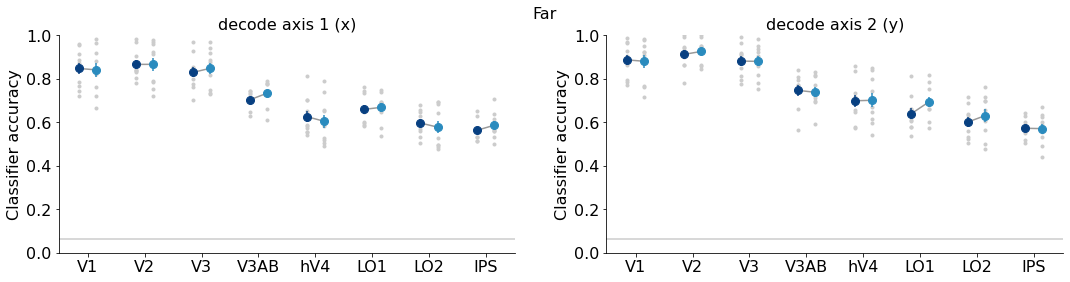

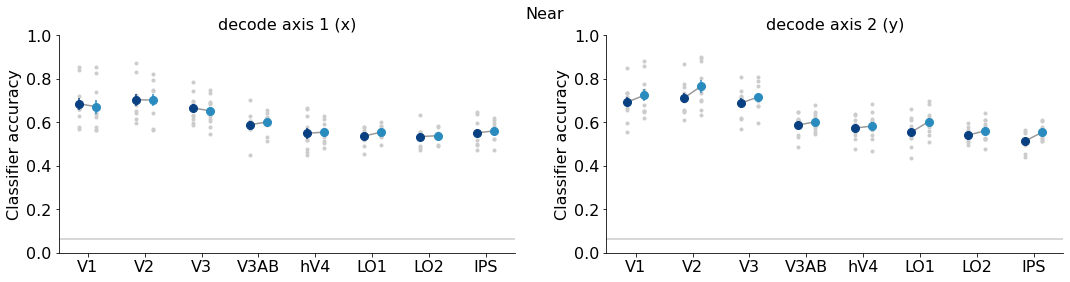

In [19]:
ti_plot = [0,1]

x_jitter = np.linspace(-0.15, 0.15,2)

for conf_vals, name in zip([acc_fartrials, acc_midtrials], \
                     ['Far','Near']):    
    
    print([np.min(conf_vals.ravel()),np.max(conf_vals.ravel())])
    plt.figure(figsize=(18,4))

    for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)']):

        ax = plt.subplot(1,2,ii+1)

        plt.axhline(1/16, color=[0.8, 0.8, 0.8])

        lh = []

        for ti in ti_plot:

            x_ticks = np.arange(n_rois) + x_jitter[ti]

            vals = conf_vals[:,:,ti,ii]
            meanvals = np.mean(vals, axis=0)
            semvals = np.std(vals, axis=0)/np.sqrt(n_subjects)

            plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti], alpha=1, \
                     markersize=8, \
                     # markerfacecolor='none', \
                    )
            h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
            lh.append(h)
            
        for ri in range(n_rois):
            
            meanvals = np.mean(conf_vals[:,ri,ti_plot,ii], axis=0)
            plt.plot([ri+x_jitter[0], ri+x_jitter[1]], meanvals,'-',color=[0.6, 0.6, 0.6],zorder=-5)

            plt.plot(ri+x_jitter, conf_vals[:,ri,ti_plot,ii].T, '.', color=[0.8, 0.8, 0.8], zorder=-10)
            
        # plt.ylim([-0.10, 0.90])
        plt.ylim([0, 1.0])
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        plt.xticks(np.arange(n_rois), roi_names)
        plt.ylabel('Classifier accuracy')

        # plt.legend(lh,np.array(task_names)[ti_plot])

        plt.title('decode %s'%axis_name)

    plt.suptitle('%s'%name)
    
#     figname = os.path.join(figfolder, 'multi_binary_conf_%s.pdf'%(name))
#     print(figname)
#     plt.savefig(figname)


In [20]:
figfolder = os.path.join(root, 'Analysis','figures')

for xx, [cvals, diffname] in enumerate(zip([acc_fartrials, acc_midtrials], \
                        ['far','middle'])):

    
    vals = copy.deepcopy(cvals[:,:,0:2,0:2])

    anova_result = stats_utils.rmanova_3way(vals, ['ROI','Task','Boundary'], \
                                            # do_shuffle=False)
                                           do_shuffle=True, n_iter=10000, rndseed = 675677+xx)

    anova_result['Pr > F'] = anova_result['Pr > F'].round(4)

    tablename = os.path.join(figfolder, 'decode_16way_binary_acc_lin1vs2_rm_anova_%s.csv'%(diffname))
    
    print(tablename)
    anova_result.to_csv(tablename)

/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decode_16way_binary_acc_lin1vs2_rm_anova_far.csv
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decode_16way_binary_acc_lin1vs2_rm_anova_middle.csv


In [21]:
for diffname in ['far','middle']:
    
    tablename = os.path.join(figfolder, 'decode_16way_binary_acc_lin1vs2_rm_anova_%s.csv'%(diffname))
    print(tablename)
    print(time.ctime(os.path.getmtime(tablename)))
    anova_result = pd.read_csv(tablename, index_col=0)
    print('\nAnova for accuracy, %s trials'%(diffname))
    
    print(anova_result)

/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decode_16way_binary_acc_lin1vs2_rm_anova_far.csv
Sat Dec 14 09:41:29 2024

Anova for accuracy, far trials
                      F Value  Num DF  Den DF  Pr > F  p (permutation)
ROI                112.859725     7.0    63.0  0.0000           0.0000
Task                 1.090059     1.0     9.0  0.3237           0.3208
Boundary            32.103368     1.0     9.0  0.0003           0.0003
ROI:Task             1.343986     7.0    63.0  0.2450           0.2449
ROI:Boundary         4.341172     7.0    63.0  0.0006           0.0005
Task:Boundary        0.765053     1.0     9.0  0.4045           0.4007
ROI:Task:Boundary    2.675085     7.0    63.0  0.0172           0.0170
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decode_16way_binary_acc_lin1vs2_rm_anova_middle.csv
Sat Dec 14 09:52:03 2024

Anova for accuracy, middle trials
                     F Value  Num DF  Den DF  Pr > F  p (permutation)
ROI                42.932359    

In [22]:
for cvals, diffname in zip([acc_fartrials, acc_midtrials], \
                        ['far','middle']):

    for ii, axis_name in enumerate(['axis1','axis2']):

        vals = copy.deepcopy(cvals[:,:,0:2,ii])

        anova_result = stats_utils.rmanova_2way(vals, ['ROI','Task'], \
                                                do_shuffle=False);
                                                # do_shuffle=True, n_iter=10000, rndseed = 243434+ii)

        
        anova_result['Pr > F'] = anova_result['Pr > F'].round(4)
    
        tablename = os.path.join(figfolder, 'decode_16way_binary_acc_rm_anova_%s_%s.csv'%(axis_name, diffname))
    
        print(tablename)
        anova_result.to_csv(tablename)

/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decode_16way_binary_acc_rm_anova_axis1_far.csv
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decode_16way_binary_acc_rm_anova_axis2_far.csv
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decode_16way_binary_acc_rm_anova_axis1_middle.csv
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decode_16way_binary_acc_rm_anova_axis2_middle.csv


In [23]:
for diffname in ['far','middle']:
    for axis_name in ['axis1','axis2']:

        tablename = os.path.join(figfolder, 'decode_16way_binary_acc_rm_anova_%s_%s.csv'%(axis_name, diffname))
        print(tablename)
        print(time.ctime(os.path.getmtime(tablename)))
        anova_result = pd.read_csv(tablename, index_col=0)
        print('\nAnova for %s accuracy, %s trials'%(axis_name, diffname))
        print(anova_result)

/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decode_16way_binary_acc_rm_anova_axis1_far.csv
Sat Dec 14 09:52:03 2024

Anova for axis1 accuracy, far trials
            F Value  Num DF  Den DF  Pr > F
ROI       76.723439     7.0    63.0  0.0000
Task       0.261976     1.0     9.0  0.6211
ROI:Task   1.907979     7.0    63.0  0.0830
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decode_16way_binary_acc_rm_anova_axis2_far.csv
Sat Dec 14 09:52:03 2024

Anova for axis2 accuracy, far trials
            F Value  Num DF  Den DF  Pr > F
ROI       96.963208     7.0    63.0  0.0000
Task       2.500765     1.0     9.0  0.1482
ROI:Task   1.992572     7.0    63.0  0.0700
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decode_16way_binary_acc_rm_anova_axis1_middle.csv
Sat Dec 14 09:52:03 2024

Anova for axis1 accuracy, middle trials
            F Value  Num DF  Den DF  Pr > F
ROI       26.640211     7.0    63.0  0.0000
Task       0.172841     1.0     9.0  0.6873
ROI:Task   0

In [24]:
for cvals, diffname in zip([acc_midtrials], \
                        ['middle']):

    for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)']):

        vals = copy.deepcopy(cvals[:,:,0:2,ii])
        
        tstats_task = np.zeros((n_rois,),dtype=float)
        pvals_task = np.zeros((n_rois,),dtype=float)
        n_subs_samedir = np.zeros((n_rois,),dtype=int)

        rndseed = 8676786
        for rr in range(n_rois):

            t1_values = vals[:,rr,0]
            t2_values = vals[:,rr,1]
            p, t = stats_utils.paired_ttest_nonpar(t1_values, t2_values, \
                                                   # n_iter=2,
                                                   n_iter=10000, \
                                                   rndseed=rndseed+rr)    
            tstats_task[rr] = t
            pvals_task[rr] = p

            subj_diffs = t1_values - t2_values
            n_subs_samedir[rr] = np.maximum(np.sum(subj_diffs>0), np.sum(subj_diffs<0))

        print('\n%s trials, %s'%(diffname, axis_name))
        task_df = pd.DataFrame({'t-stat for task 1 > task 2': tstats_task, \
                                'pvalue': pvals_task, \
                                'n_subs_indiv': n_subs_samedir}, \
                                  index=roi_names)
        print(task_df.round(3))


middle trials, axis 1 (x)
      t-stat for task 1 > task 2  pvalue  n_subs_indiv
V1                         1.508   0.196             7
V2                         0.079   0.936             6
V3                         0.929   0.372             6
V3AB                      -0.701   0.500             6
hV4                       -0.240   0.830             5
LO1                       -1.495   0.174             8
LO2                       -0.243   0.844             6
IPS                       -0.461   0.655             7

middle trials, axis 2 (y)
      t-stat for task 1 > task 2  pvalue  n_subs_indiv
V1                        -1.635   0.135             8
V2                        -3.281   0.014             9
V3                        -1.646   0.108             7
V3AB                      -0.691   0.518             6
hV4                       -0.416   0.692             6
LO1                       -2.296   0.016             9
LO2                       -1.016   0.381             6
IPS        